In [1]:
!apt-get update && apt-get install -y libboost-all-dev build-essential cmake freeglut3-dev mesa-utils libgl1-mesa-glx
!apt-get install -y build-essential
!pip install git+https://github.com/MPI-IS/mesh.git

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]                
Get:3 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3892 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1239 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2737 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1381 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]       
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]     
Get:12 https://ppa.launchpadcontent.net/d

In [2]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.3 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=d899b19791ac499fcb2a4aa396e463cb3e95824a65f9fb1c47926075acb96b2a
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 258.3 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of pytorch3d to determine which ver

In [7]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 233.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 262.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 233.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import os
import torch
import pytorch3d
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [9]:
!pip install git+https://github.com/MPI-IS/mesh.git
!pip install kaolin
!pip install torch_geometric
!pip install pyg_lib-0.3.0+pt113cu117-cp38-cp38-linux_x86_64.whl
!pip install torch_cluster-1.6.1+pt113cu117-cp38-cp38-linux_x86_64.whl
!pip install torch_scatter-2.1.1+pt113cu117-cp38-cp38-linux_x86_64.whl
!pip install torch_sparse-0.6.15+pt113cu117-cp38-cp38-linux_x86_64.whl

  Cloning https://github.com/MPI-IS/mesh.git to /tmp/pip-req-build-qig1rga0
  Running command git clone --filter=blob:none --quiet https://github.com/MPI-IS/mesh.git /tmp/pip-req-build-qig1rga0
  Resolved https://github.com/MPI-IS/mesh.git to commit 49e70425cf373ec5269917012bda2944215c5ccd
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for kaolin: filename=kaolin-0.1-py3-none-any.whl size=1255 sha256=8df3978f13a62b92ceb83f452a99a5cfdf739e75fb830719e992f90e103a2b15
  Stored in directory: /root/.cache/pip/wheels/cf/de/5c/8289eba83f6eb65974512cbf4c9a10e530a0da88fdf2d62be6
Successfully built kaolin

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [15]:
import os
if not os.path.exists('/content/Cloth2Tex'):
    !git clone https://github.com/alexncoleman/Cloth2Tex.git

Cloning into 'Cloth2Tex'...
remote: Enumerating objects: 1373, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1373 (delta 30), reused 52 (delta 21), pack-reused 1310 (from 1)
Receiving objects: 100% (1373/1373), 154.63 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (1582/1582), done.
[Errno 2] No such file or directory: '/content/Cloth2Tex'
/workspace


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [24]:
!python phase1_inference.py --g 3_Tshirt --s 0.75 --d "1_tshirt" --id 1 --steps_one 1500 --steps_two 2500

Namespace(g='3_Tshirt', d='1_tshirt', s=0.75, id=1.0, steps_one=1500, steps_two=2500)
[Cloth2Tex] template/reference/3_Tshirt/mesh/mesh.obj
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py

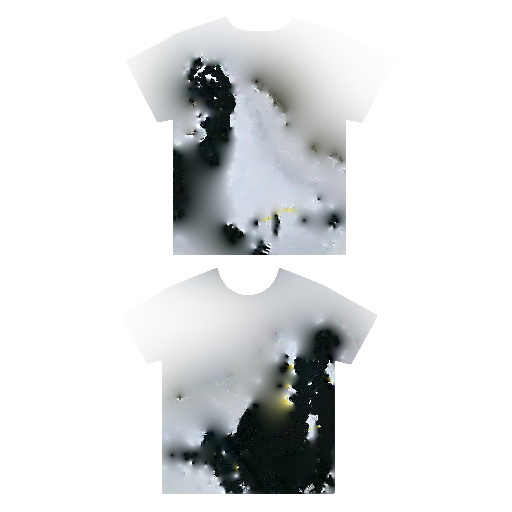

In [25]:
from IPython.display import Image
Image("/workspace/Cloth2Tex/experiments/1_tshirt/0_texture_uv_1000.jpg")